In [156]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import svm

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [157]:
list(df)

['fullVisitorId',
 'visitNumber',
 'device.browser.isChrome',
 'device.isMobile',
 'os.isWindows',
 'totals.hits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'trafficSource.isdirect',
 'isWeekend',
 'Population',
 'Pop. Density (per sq. mi.)',
 'GDP ($ per capita)',
 'Literacy (%)',
 'Phones (per 1000)',
 'isDec',
 'geoNetwork.continent_Africa',
 'geoNetwork.continent_Americas',
 'geoNetwork.continent_Asia',
 'geoNetwork.continent_Europe',
 'geoNetwork.continent_Oceania',
 'geoNetwork.subContinent_Australasia',
 'geoNetwork.subContinent_Caribbean',
 'geoNetwork.subContinent_Central America',
 'geoNetwork.subContinent_Central Asia',
 'geoNetwork.subContinent_Eastern Africa',
 'geoNetwork.subContinent_Eastern Asia',
 'geoNetwork.subContinent_Eastern Europe',
 'geoNetwork.subContinent_Melanesia',
 'geoNetwork.subContinent_Micronesian Region',
 'geoNetwork.subContinent_Middle Africa',
 'geoNetwork.subContinent_Northern Africa',
 'geoNetwork.subContinent_Northern America',
 'geoNet

In [158]:

df = pd.read_csv("../cleaned_train.csv")
df = df.drop(columns = ['Unnamed: 0'])

In [132]:
X_train, Locked_X, y_train, Locked_y = train_test_split(df.drop(columns = ['totals.transactionRevenue', 'class_pred', 'fullVisitorId']), df[['totals.transactionRevenue', 'class_pred', 'fullVisitorId']], test_size=0.33, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, shuffle = False)
print("X_train: " + str(X_train.shape))
print("X_test: " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test: " + str(y_test.shape))
print("Locked_X: " + str(Locked_X.shape))
print("Locked_y: " + str(Locked_y.shape))


print("sum locked: ", sum(Locked_y['class_pred']))
print("sum train: ", sum(y_train['class_pred']))
print("sum test: ", sum(y_test['class_pred']))

X_train: (766871, 57)
X_test: (377714, 57)
y_train: (766871, 3)
y_test: (377714, 3)
Locked_X: (563752, 57)
Locked_y: (563752, 3)
('sum locked: ', 6247.0)
('sum train: ', 8406.0)
('sum test: ', 3861.0)


# Fit PCA

In [133]:
#PCA keeping 95% of variance
pca = PCA(.95)

pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(pca.singular_values_)  



[1552.81098771 1200.75632511 1031.19128675  873.06689032  849.09972136
  555.84804885  546.88567088  528.94351139  495.55638516  450.3575826
  439.24008569  425.66397314  401.99561355  381.43843277  372.28267389
  365.01160136  356.12259497  348.600143    325.31897493  310.82613346
  263.56327102]


In [155]:
print(len(pca.singular_values_))

21


# Fit Random Forest

In [134]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [136]:
rf_class = RandomForestClassifier(n_estimators=100, min_samples_leaf = .1, random_state=0, class_weight='balanced')
# rf.fit(X_train, y_train['class_pred'])
# y_pred = rf.predict(X_test)
print(cross_val_score(rf_class, X_train, y_train['class_pred'], cv=3))

rf_class.fit(X_train, y_train['class_pred'])
y_pred = rf_class.predict(X_test)
print("Confusion matrix no PCA: ", confusion_matrix(y_test['class_pred'], y_pred))
print("f1-score no PCA: ", f1_score(y_test['class_pred'], y_pred))

('Confusion matrix no PCA: ', array([[330147,  43706],
       [   111,   3750]]))
('f1-score no PCA: ', 0.14615039850341993)


                                            Gini-importance
channelGrouping_Referral                       0.000000e+00
geoNetwork.subContinent_Eastern Africa         0.000000e+00
geoNetwork.subContinent_Western Europe         0.000000e+00
channelGrouping_Paid Search                    0.000000e+00
geoNetwork.subContinent_Melanesia              0.000000e+00
geoNetwork.subContinent_Eastern Europe         0.000000e+00
geoNetwork.continent_Africa                    0.000000e+00
geoNetwork.subContinent_Polynesia              0.000000e+00
geoNetwork.subContinent_Southern Asia          0.000000e+00
geoNetwork.subContinent_Central Asia           0.000000e+00
geoNetwork.subContinent_Southeast Asia         0.000000e+00
geoNetwork.subContinent_Northern Europe        0.000000e+00
channelGrouping_Display                        0.000000e+00
channelGrouping_(Other)                        0.000000e+00
geoNetwork.subContinent_Eastern Asia           0.000000e+00
geoNetwork.continent_Oceania            

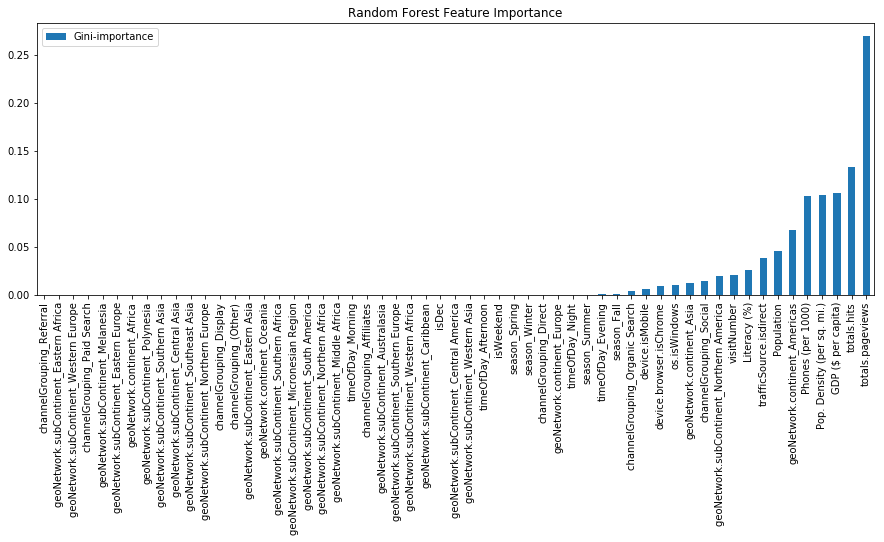

In [149]:
# print("Confusion matrix no PCA: ", confusion_matrix(y_test['class_pred'], y_pred))
# print("f1-score no PCA: ", f1_score(y_test['class_pred'], y_pred))
rf_class.feature_importances_


%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, rf_class.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
print(importances.sort_values(by='Gini-importance'))
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,5), title = "Random Forest Feature Importance")
print(type(importances.sort_values(by='Gini-importance')))

In [152]:
rf_pca = RandomForestClassifier(n_estimators=100, min_samples_leaf = .1, random_state=0, class_weight='balanced')
print(cross_val_score(rf_pca, X_train_pca, y_train['class_pred'], cv=3))

rf_pca.fit(X_train_pca, y_train['class_pred'])
y_pred_pca = rf_pca.predict(X_test_pca)


print("Confusion matrix PCA: ", confusion_matrix(y_test['class_pred'], y_pred_pca))
print("f1-score PCA: ", f1_score(y_test['class_pred'], y_pred_pca))

KeyboardInterrupt: 

In [153]:
print("Confusion matrix PCA: ", confusion_matrix(y_test['class_pred'], y_pred_pca))
print("f1-score PCA: ", f1_score(y_test['class_pred'], y_pred_pca))


('Confusion matrix PCA: ', array([[338678,  35175],
       [    78,   3783]]))
('f1-score PCA: ', 0.17669726056190008)


# Fit Lasso/Ridge/RF regression ensemble

In [28]:
# X_Reg = X_test[y_pred_pca ==1]
# y_Reg = y_test[y_pred_pca == 1]

# X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_Reg, y_Reg, test_size=0.33, shuffle = False)

In [49]:
#or train on same training as classification
X_train_reg = X_train[y_train['class_pred']==1]
y_train_reg = y_train[y_train['class_pred']==1]

X_test_reg = X_test[y_pred_pca ==1]
y_test_reg = y_test[y_pred_pca == 1]

In [110]:
rf = RandomForestRegressor(n_estimators = 100, max_features = 'log2', min_samples_leaf= 0.001) 
ridge = Ridge(alpha = .202)
lasso = Lasso(alpha = 1e-15)
svr = svm.SVR(C= 10000.0, degree = 3, kernel = 'poly')

rf.fit(X_train_reg, y_train_reg['totals.transactionRevenue'])
ridge.fit(X_train_reg, y_train_reg['totals.transactionRevenue'])
lasso.fit(X_train_reg, y_train_reg['totals.transactionRevenue'])
svr.fit(X_train_reg, y_train_reg['totals.transactionRevenue'])


rf_pred = rf.predict(X_test_reg)
ridge_pred = ridge.predict(X_test_reg)
lasso_pred = lasso.predict(X_test_reg)
svr_pred = svr.predict(X_test_reg)




/Users/cassidylitch/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [116]:
pred_all = pd.DataFrame({"random_forest": rf_pred, "ridge": ridge_pred, "lasso": lasso_pred, "svr": svr_pred}).mean(axis=1)
pred_rf_svr = pd.DataFrame({"random_forest": rf_pred, "svr": svr_pred}).mean(axis=1)
pred_rf_svr_lass = pd.DataFrame({"random_forest": rf_pred, "svr": svr_pred, "lasso": lasso_pred}).mean(axis=1)

In [117]:
import math
mse_all=mean_squared_error(y_test_reg['totals.transactionRevenue'], pred_all)
rmse_all=math.sqrt(mse_all)
print("All: root mean squared error", rmse_all)

mse_rf_svr=mean_squared_error(y_test_reg['totals.transactionRevenue'], pred_rf_svr)
rmse_rf_svr=math.sqrt(mse_rf_svr)
print("RF/SVR: root mean squared error", rmse_rf_svr)


mse_rf_svr_lass=mean_squared_error(y_test_reg['totals.transactionRevenue'], pred_rf_svr_lass)
rmse_rf_svr_lass=math.sqrt(mse_rf_svr_lass)
print("RF/SVR/Lasso: root mean squared error", rmse_rf_svr_lass)


mse_rf=mean_squared_error(y_test_reg['totals.transactionRevenue'], rf_pred)
rmse_rf=math.sqrt(mse_rf)
print("RF: root mean squared error", rmse_rf)

mse_ridge=mean_squared_error(y_test_reg['totals.transactionRevenue'], ridge_pred)
rmse_ridge=math.sqrt(mse_ridge)
print("Ridge: root mean squared error", rmse_ridge)

mse_lasso=mean_squared_error(y_test_reg['totals.transactionRevenue'], lasso_pred)
rmse_lasso=math.sqrt(mse_lasso)
print("Lasso:root mean squared error", rmse_lasso)

mse_svr=mean_squared_error(y_test_reg['totals.transactionRevenue'], svr_pred)
rmse_svr=math.sqrt(mse_svr)
print("svr:root mean squared error", rmse_svr)

('All: root mean squared error', 231634269.57672933)
('RF/SVR: root mean squared error', 148543483.56945413)
('RF/SVR/Lasso: root mean squared error', 201651237.76313528)
('RF: root mean squared error', 167847929.43034953)
('Ridge: root mean squared error', 339250199.055082)
('Lasso:root mean squared error', 401394158.36334455)
('svr:root mean squared error', 137889050.5921184)


In [113]:
import numpy as np
np.sort([rmse_comb, rmse_rf, rmse_ridge, rmse_lasso, rmse_svr])

array([1.37889051e+08, 1.67847929e+08, 2.81691105e+08, 3.39250199e+08,
       4.01394158e+08])

In [119]:
#Combine results like Kaggle wants

#y_test['final_prediction'] = y_pred_pca

def addFinalPrediction(classPred, regPred):
    total_pred = []
    cnt = 0
    for x in classPred: 
        if x == 0:
            total_pred.append(x)
        else:
            total_pred.append(regPred[cnt])
            cnt +=1
    return total_pred
        
        
        
y_test['final_prediction'] = addFinalPrediction(y_pred_pca, pred_rf_svr)

In [120]:
mse=mean_squared_error(y_test['totals.transactionRevenue'], y_test['final_prediction'])
rmse=math.sqrt(mse)
print("Final prediction per entry: ", rmse)

('Final prediction per entry: ', 47773693.06059583)


In [64]:
list(y_test)

['totals.transactionRevenue',
 'class_pred',
 'fullVisitorId',
 'final_prediction']

# Combine by User for Kaggle

In [121]:
#group predicted/true values by id number
group = y_test.groupby('fullVisitorId')

dfpredictions = group.apply(lambda x: x['final_prediction'].unique())
dftrue = group.apply(lambda x: x['totals.transactionRevenue'].unique())




In [122]:
concatenated = pd.concat([dfpredictions, dftrue], axis=1)
concatenated.rename(columns={0: "PredictedLogRevenue", 1: "true"},inplace = True)
concatenated.head()

,predicted,true
fullVisitorId,,
4823595352351,[0.0],[0.0]
17196000342279,[0.0],[0.0]
18672749561458,[0.0],[0.0]
58970809397690,[0.0],[0.0]
59381693533730,[0.0],[0.0]


In [123]:
def sumSeries(df, col):
    newCol = []
    for x in df[col]:
#         print(np.sum(x) + 1)
        if np.sum(x) <0:
            newCol.append(math.log( 1))
        else:
            newCol.append(math.log(np.sum(x) + 1))
    return newCol

concatenated['PredictedLogRevenue'] = sumSeries(concatenated, 'PredictedLogRevenue')
print("done 1")
concatenated['true'] = sumSeries(concatenated, 'true')



done 1


In [124]:
mse=mean_squared_error(concatenated['true'],concatenated['predicted'])
rmse=math.sqrt(mse)
print(rmse)

5.62751553027


In [128]:
X_train_pca.shape

(766871, 21)